Using device: cuda
GPU memory cleared. Initial allocated: 378.68 MiB


Downloading...
From: https://drive.google.com/uc?id=1etqmQsksNIWBvBQ4r8ZFk_3FJlLWr8Rr
To: /content/models/cifar10/Linf/Engstrom2019Robustness.pt
100%|██████████| 94.4M/94.4M [00:02<00:00, 45.9MB/s]


Model loaded successfully.
Attack used: LInfFMNAttack(steps=100, max_stepsize=1.0, init_attack=None, min_stepsize=0.01, binary_search_steps=10, gamma=0.05, p=inf, dual=1)
Processing batch 1 with 100 samples...
Total samples processed: 100

Processing batch 2 with 100 samples...
Total samples processed: 200

Processing batch 3 with 100 samples...
Total samples processed: 300

Processing batch 4 with 100 samples...
Total samples processed: 400

Processing batch 5 with 100 samples...
Total samples processed: 500

Processing batch 6 with 100 samples...
Total samples processed: 600

Processing batch 7 with 100 samples...
Total samples processed: 700

Processing batch 8 with 100 samples...
Total samples processed: 800

Processing batch 9 with 100 samples...
Total samples processed: 900

Processing batch 10 with 100 samples...
Total samples processed: 1000

--- Analysis ---
Clean Accuracy: 88.70%
Robust Accuracy ($\epsilon$=8.00): 54.20%
Mean Minimal Epsilon: 9.41
Median Minimal Epsilon: 8.58

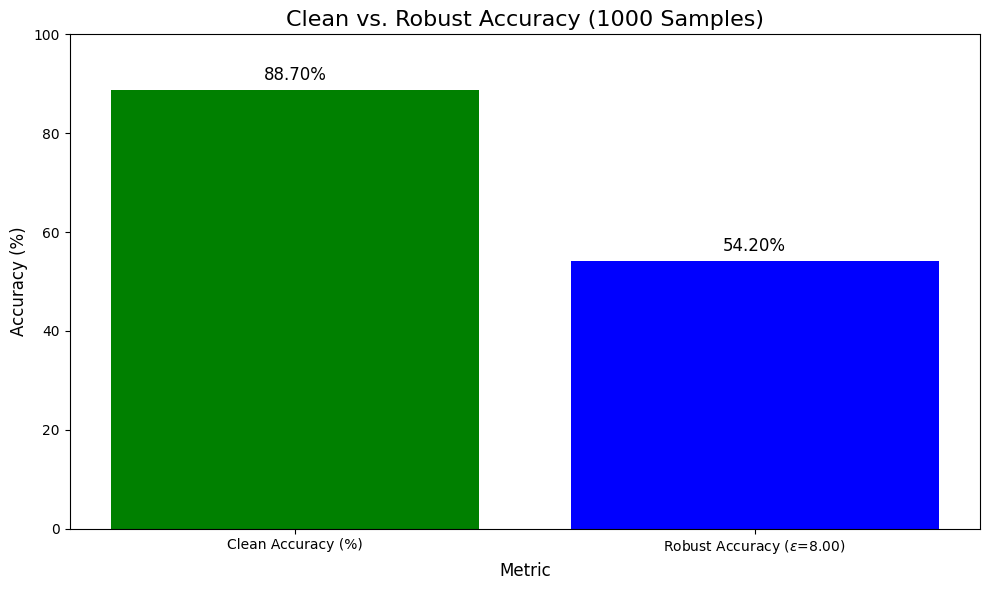

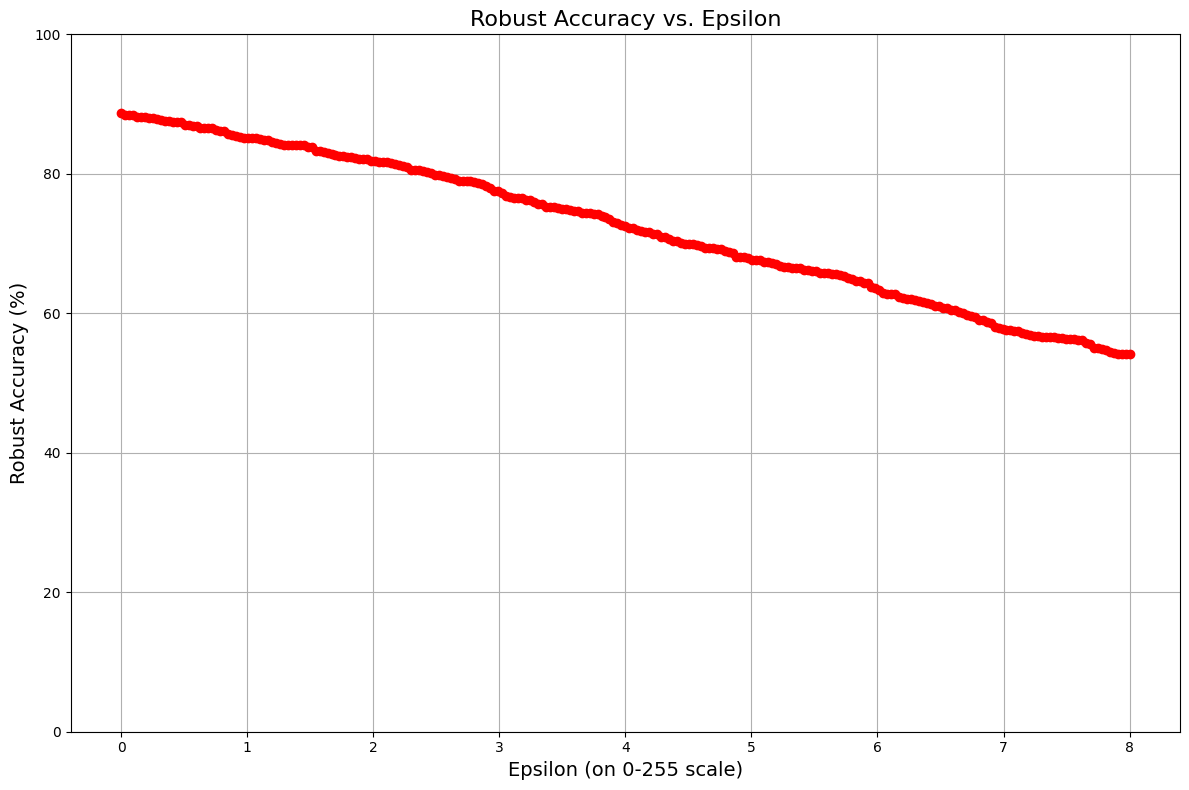

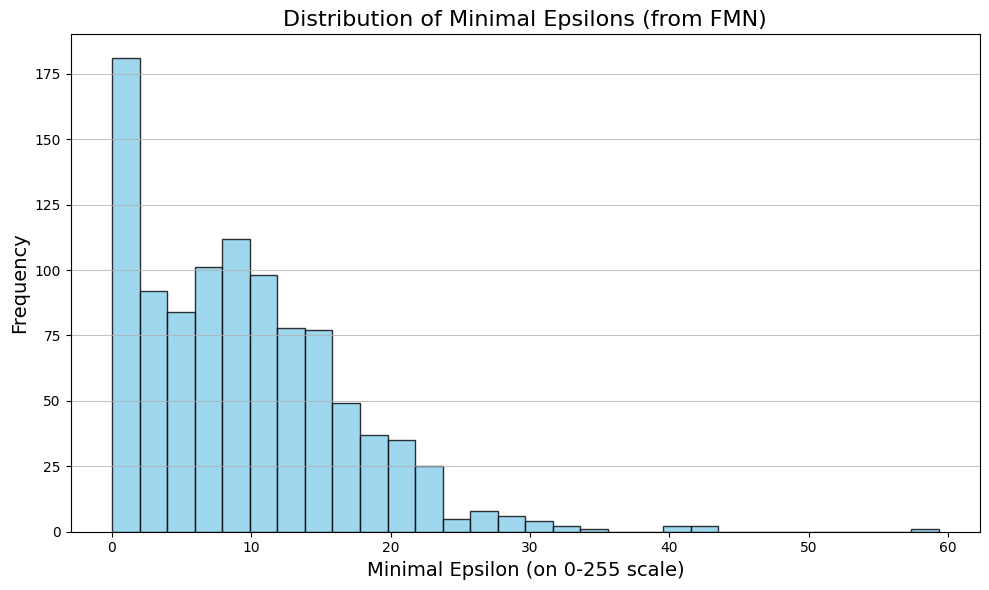

In [7]:
import torch
import torch.nn as nn
from robustbench.utils import load_model
import foolbox as fb
import numpy as np
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os

# --- Configuration ---
# Set the number of samples to process. Set to a small number for a quick test.
NUM_SAMPLES_TO_PROCESS = 1000
BATCH_SIZE = 100
MAX_EPSILON_BENCHMARK = 8 / 255  # Standard benchmark for CIFAR-10 Linf
EPSILON_STEPS = 255  # Number of epsilon values for the accuracy vs. epsilon plot

# --- Helper Functions ---
def get_device():
    """Determines and returns the best available device (GPU or CPU)."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    if device.type == "cuda":
        torch.cuda.empty_cache()
        gc.collect()
        print(f"GPU memory cleared. Initial allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MiB")
    return device

def load_and_prepare_model(device):
    """Loads a pre-trained robust model and wraps it for Foolbox."""
    try:
        model = load_model(
            model_name="Engstrom2019Robustness",
            dataset="cifar10",
            threat_model="Linf"
        ).to(device)
        model.eval()
        print("Model loaded successfully.")
        return fb.PyTorchModel(model, bounds=(0, 1))
    except (torch.cuda.OutOfMemoryError, RuntimeError) as e:
        print(f"Error loading model: {e}. Switching to CPU.")
        device = torch.device("cpu")
        model = load_model(
            model_name="Engstrom2019Robustness",
            dataset="cifar10",
            threat_model="Linf"
        ).to(device)
        model.eval()
        return fb.PyTorchModel(model, bounds=(0, 1))

def load_cifar10_data():
    """Loads the CIFAR-10 test dataset with error handling."""
    transform = transforms.Compose([transforms.ToTensor()])
    try:
        return CIFAR10(root='./data', train=False, download=True, transform=transform)
    except Exception as e:
        print(f"Failed to download CIFAR-10 dataset: {e}")
        print("Please check your internet connection or download it manually.")
        raise

def plot_accuracy_bar_chart(clean_acc, robust_acc, title, epsilon):
    """Generates and displays a bar chart comparing clean and robust accuracy."""
    plt.figure(figsize=(10, 6))
    metrics = [clean_acc, robust_acc]
    metric_names = ['Clean Accuracy (%)', f'Robust Accuracy ($\epsilon$={epsilon*255:.2f})']
    plt.bar(metric_names, metrics, color=['orange', 'purple'])
    plt.ylim(0, 100)
    plt.title(title, fontsize=16)
    plt.xlabel('Metric', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    for i, v in enumerate(metrics):
        plt.text(i, v + 2, f'{v:.2f}%', ha='center', fontsize=12)
    plt.tight_layout()
    plt.show()

def plot_accuracy_vs_epsilon(epsilons, accuracies):
    """Generates and displays a line plot of robust accuracy vs. epsilon."""
    plt.figure(figsize=(12, 8))
    plt.plot(epsilons * 255, accuracies, marker='o', color='green', linestyle='-')
    plt.xlabel('Epsilon (on 0-255 scale)', fontsize=14)
    plt.ylabel('Robust Accuracy (%)', fontsize=14)
    plt.title('Robust Accuracy vs. Epsilon', fontsize=16)
    plt.ylim(0, 100)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_epsilon_distribution(epsilons):
    """Generates and displays a histogram of minimal epsilons."""
    plt.figure(figsize=(10, 6))
    plt.hist(epsilons * 255, bins=30, color='skyblue', alpha=0.8, edgecolor='black')
    plt.xlabel('Minimal Epsilon (on 0-255 scale)', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title('Distribution of Minimal Epsilons (from FMN)', fontsize=16)
    plt.grid(axis='y', alpha=0.75)
    plt.tight_layout()
    plt.show()

# --- Main Execution Flow ---
def main():
    """Main function to run the adversarial attack and analysis pipeline."""
    device = get_device()
    fmodel = load_and_prepare_model(device)
    test_dataset = load_cifar10_data()
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Initialize the attack
    attack = fb.attacks.LInfFMNAttack()
    print(f"Attack used: {attack}")

    # Set up epsilon values for the robust accuracy vs. epsilon plot
    epsilons_to_test = np.linspace(0, MAX_EPSILON_BENCHMARK, EPSILON_STEPS)

    all_clean_preds = []
    all_test_labels = []
    all_fmn_perturbations = []
    robust_accuracies_vs_epsilon = {eps: [] for eps in epsilons_to_test}

    total_samples_processed = 0
    for i, (images, labels) in enumerate(test_loader):
        # Limit the number of samples processed
        if total_samples_processed >= NUM_SAMPLES_TO_PROCESS:
            break

        images, labels = images.to(device), labels.to(device)
        samples_in_batch = images.shape[0]

        with torch.no_grad():
            clean_preds = fmodel(images).argmax(dim=1)
        all_clean_preds.append(clean_preds.cpu())
        all_test_labels.append(labels.cpu())

        print(f"Processing batch {i+1} with {samples_in_batch} samples...")

        # Run FMN attack to find minimal perturbations
        try:
            advs_fmn, _, _ = attack(fmodel, images, labels, epsilons=None)
            perturbations = torch.norm((advs_fmn - images).reshape(advs_fmn.shape[0], -1), p=float('inf'), dim=1)
            all_fmn_perturbations.extend(perturbations.cpu().numpy())
        except Exception as e:
            print(f"Attack failed on batch {i+1}: {e}")
            continue

        # Evaluate robust accuracy for each epsilon threshold
        for eps_threshold in epsilons_to_test:
            # Clip the adversarial examples to the current epsilon threshold
            clipped_advs = images + torch.clamp(advs_fmn - images, -eps_threshold, eps_threshold)
            clipped_advs = torch.clamp(clipped_advs, 0, 1)

            adv_preds = fmodel(clipped_advs).argmax(dim=1)
            correct_adv = (adv_preds == labels).sum().item()
            robust_accuracies_vs_epsilon[eps_threshold].append(correct_adv)

        total_samples_processed += samples_in_batch
        print(f"Total samples processed: {total_samples_processed}\n")

        # Aggressive memory cleanup for each batch
        del images, labels, clean_preds, advs_fmn
        gc.collect()
        if device.type == "cuda":
            torch.cuda.empty_cache()

    if not all_test_labels:
        print("No samples were processed. Exiting.")
        return

    # --- Analysis and Plotting ---
    print("--- Analysis ---")
    all_test_labels_combined = torch.cat(all_test_labels)
    all_clean_preds_combined = torch.cat(all_clean_preds)

    clean_acc = (all_clean_preds_combined == all_test_labels_combined).float().mean().item() * 100
    print(f"Clean Accuracy: {clean_acc:.2f}%")

    # Calculate and print robust accuracy for the benchmark epsilon
    benchmark_correct = sum(robust_accuracies_vs_epsilon[MAX_EPSILON_BENCHMARK])
    robust_acc_benchmark = benchmark_correct / total_samples_processed * 100
    print(f"Robust Accuracy ($\epsilon$={MAX_EPSILON_BENCHMARK*255:.2f}): {robust_acc_benchmark:.2f}%")

    # Calculate robust accuracies for all epsilons for the plot
    final_robust_accuracies = [sum(robust_accuracies_vs_epsilon[eps]) / total_samples_processed * 100 for eps in epsilons_to_test]

    # Calculate minimal epsilon stats
    mean_epsilon_fmn = np.mean(all_fmn_perturbations) * 255
    median_epsilon_fmn = np.median(all_fmn_perturbations) * 255
    print(f"Mean Minimal Epsilon: {mean_epsilon_fmn:.2f}")
    print(f"Median Minimal Epsilon: {median_epsilon_fmn:.2f}")

    # Generate Plots
    plot_accuracy_bar_chart(clean_acc, robust_acc_benchmark,
                            f'Clean vs. Robust Accuracy ({total_samples_processed} Samples)',
                            MAX_EPSILON_BENCHMARK)
    plot_accuracy_vs_epsilon(epsilons_to_test, final_robust_accuracies)
    plot_epsilon_distribution(np.array(all_fmn_perturbations))

if __name__ == "__main__":
    main()